# A tensorflow implementation of Pix2pix GAN
Paper : [Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/abs/1611.07004)

## Results from original paper: 

<img src="https://phillipi.github.io/pix2pix/images/teaser_v3.jpg" alt="drawing" width="600"/>

# An overview and simplified working of GAN(generative adversarial Network)

1) GAN is basically used to generate Data similar to the data of a given dataset, by word similar, here i mean, the underlying structure of generated data and given dataset is same.<br>

2) GAN's have several components as follows :<br><br>
     2.1 Generator : Use to predict whether the given input is True data or fake Data(the one generated by the generator)<br>
     2.2 Discriminator : Use to take Random Noise and generate a fake Data which should be able to confuse the Generator<br>
     2.3 Random Noise : use to genrate false data via Generator<br>
     2.4 Generator loss : usually cross-entropy loss, which increases if the genearted fake data by the generator is unable to fool the discriminator.<br>
     2.5 Discriminator loss : cross-entropy loss, which increases if discriminator predict the fake data as true data<br>
     2.6 True Input : The actual true dataset<br>
 
3) Working of Discriminator loss :
It just takes the mixture of equal amount of real and fake data with fake data as ther target label as 0 and real data with their target label as 1.

4) Working of Generator loss :
Generator loss is basically composed of the discriminator loss i.e. it include the discriminator model, what we do here is, we create the fake outputs from the generator and mark their label as 1( i.e. as if they are real data) and pass the combination through the discriminator and the loss of the discriminator would then be backpropogated to the generator model to tune its variable.

Since the discrimiator is trianed to predict real and fake data, therefore the data passed above should give large value of the loss if discriminator is working correctly, which in turn tune the generator to create more realistic data, so that the discriminator can be fooled.



### Need of Conditional GAN :
Since we are generated the fake data such that it is similar to the real data, but it is generated from any noisy vector, thus its output is unpredicted i.e. the output will still be like the real data but it can be like any point/data of the real data, and thus we don't have control over the generated output from the generator, therefore we supply an addition information with noise which directs our generator to create data similar to the additional information(which is basically a real data, similar to which we want to create the fake data) we passed it with noise.

### Use of PIX to PIX.
Here cGAN's is use to generate the translated image from the original image via the generator, via the generator for example a street view image from the satellite image, 

#### Key difference from GAN :
* Input to the Generator : input to the generator is the original image whose translated image is need to be created.
* Input to the Discriminator : mixture of A and B, where A = concatenated image, form by combining the real image and its real transformed image and B =  fake transformed image with its real image, here A would have target label as 1 and B would have target label as 0
* Loss of the Generator : Generator loss is the sum of the loss A and B, such that A = loss from the Discriminator while passing the fake data with target label as 1 through it, and B = Mean Square loss error obtained between the fake transformed image generated by the Generator with its corresponding real image(not the original transformed image).

Also note that the above combination of A and B in the generator loss is in the ratio of 1:100

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import *

import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
AUTOTUNE = tf.data.AUTOTUNE

init = tf.keras.initializers.RandomNormal(stddev=0.02)

# Data loading And Processing

In [2]:
TRAIN = "../input/pix2pix-dataset/facades/facades/train/*"
TEST = "../input/pix2pix-dataset/facades/facades/test/*"

In [3]:
list_train = tf.data.Dataset.list_files(TRAIN, shuffle=True)
list_test = tf.data.Dataset.list_files(TEST, shuffle=False)

print(tf.data.experimental.cardinality(list_train).numpy())
print(tf.data.experimental.cardinality(list_test).numpy())

2022-07-19 14:38:53.306019: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 14:38:53.412185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 14:38:53.413392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 14:38:53.417294: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

400
106


In [4]:
def decode_img(img):
    """This method is use to read image (creating two images from a single image) from disk and normalize it """
    img = tf.io.read_file(img)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (256,512))
    
    input_img, target_img = img[:,:256], img[:,256:]
    # Normalize
    input_img, target_img = normalize(input_img, target_img)
    # Convert to float32
    input_img = tf.cast(input_img, tf.float32)
    target_img = tf.cast(target_img, tf.float32)
    return target_img, input_img


def normalize(input_img, target_img):
    """The normalisation is done by converting each pixel value to in the range of [-1,1]"""
    input_img = input_img / 127.5 - 1
    target_img = target_img / 127.5 - 1
    return input_img, target_img

def denormalize(img):
    """To denormalize image from range of [-1,1] to [0,255] range"""
    img = (img + 1) * 127.5
    return img

In [5]:
def resize(input_image, real_image, height, width):
    """method to resize images which is basically enlarging the images from the shape of 
    256x256 to 286x286, and for that using the nearest pixel to fill the emptly pixels i.e 286-256 = 30 pixels"""
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

def random_crop(input_image, real_image):
    """This method is used to crop the input image randomly, basically first stacking i.e. concatenation 
    the two input image and real image and then cropping the concatenation and returning the them seperatly"""
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, 256, 256, 3])

    return cropped_image[0], cropped_image[1]

@tf.function()
def random_jitter(input_img, target_img):
    """This is basically the method to perform data-augmentation in the images, to cope with variability in the 
    future images i.e. apart from the trained images."""
    target_img, input_img = resize(input_img, target_img, 286, 286)
    target_img, input_img = random_crop(input_img, target_img)

    if tf.random.uniform(()) > 0.5:
        target_img = tf.image.flip_left_right(target_img) #incorporating flipping as augmentation 
        input_img = tf.image.flip_left_right(input_img)

    return input_img, target_img

In [6]:
train_ds = list_train.map(decode_img, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(random_jitter, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.repeat()
train_ds = train_ds.batch(1)
train_ds = train_ds.prefetch(AUTOTUNE)
train_ds

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>

In [7]:
test_ds = list_test.map(decode_img, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(1)
test_ds = test_ds.prefetch(AUTOTUNE)
test_ds

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>

2022-07-19 14:38:56.719398: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


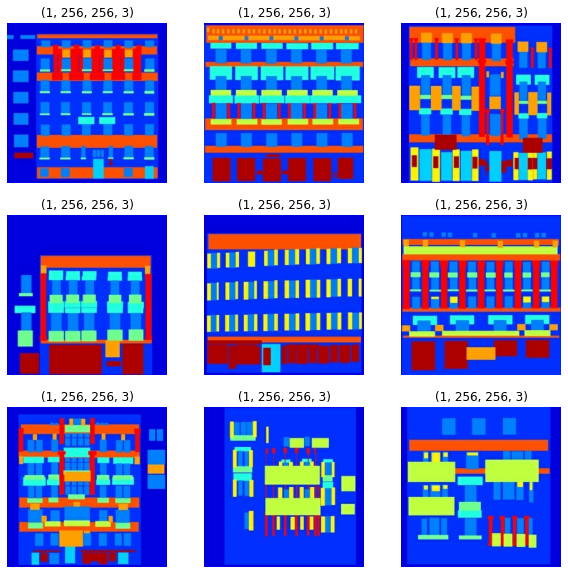

In [8]:
plt.figure(figsize=(10, 10))
counter = 0
for sat, map_ in test_ds:
    plt.subplot(3, 3, counter + 1)
    plt.imshow(np.squeeze(sat) * 0.5 + 0.5)
    plt.title(sat.shape)
    plt.axis("off")
    counter+=1
    if counter==9: break
        
        
# Note that the below images looks like segmentation maps, and thus Unet is used, to generate segmentation map images from sat images

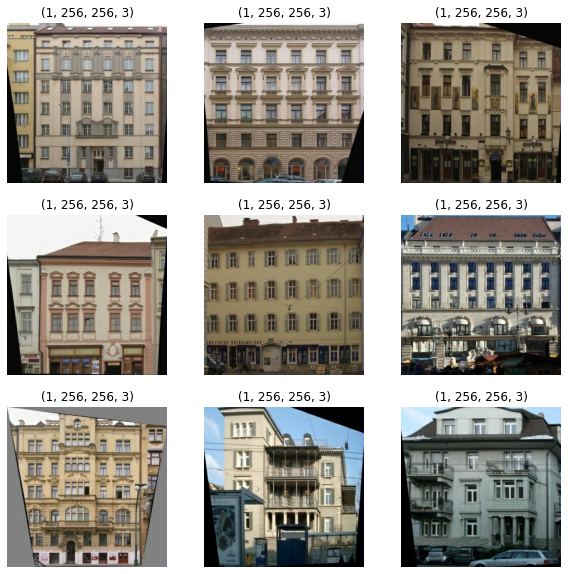

In [9]:
plt.figure(figsize=(10, 10))
counter = 0
for sat, map_ in test_ds:
    plt.subplot(3, 3, counter + 1)
    plt.imshow(np.squeeze(map_)* 0.5 + 0.5)
    plt.title(sat.shape)
    plt.axis("off")
    counter+=1
    if counter==9: break

# Discriminator

In [10]:
def Discriminator(image_shape):
    """Here we are creating the discriminator model like a simple computer vision model
       to detect the input as fake or real based on the label we assigned to the input.
    """
    image = Input(shape=image_shape)    # sat images
    target = Input(shape=image_shape)   # map
    
    concat = Concatenate()([image, target])
    
    x = Conv2D(64, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(concat)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(128, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(256, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(512, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(1, kernel_size=(4,4), padding='same', kernel_initializer=init)(x)
    x = Activation('sigmoid')(x)
    
    model = Model([image, target], x)
    return model

In [11]:
Discriminator = Discriminator((256,256,3))
Discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256, 256, 6)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 6208        concatenate[0][0]            

# Generator

In [12]:
# below is the encoder and decoder block for the Unet which is used as Generator

def encoder(inputs, filters, batch_norm=True):
    x = Conv2D(filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(inputs)
    if batch_norm:
        x = BatchNormalization()(x, training=True)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def decoder(inputs, skip, filters, dropout=True):
    x = Conv2DTranspose(filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(inputs)
    x = BatchNormalization()(x, training=True)
    if dropout:
        x = Dropout(0.5)(x, training=True)
    x = Concatenate()([x, skip])
    x = Activation('relu')(x)
    return x

In [13]:
def Generator(input_shape):
    """Here for Generator Unet model is used, thus the above cell has encode and decoder block for the below Unet
       Also note that unet is generall used to generate segmentation map, so does here we are generating the map image 
       which is like segmentation map, from the sat images i.e. the original images"""
    
    inputs = Input(shape=input_shape)
    
    x1 = encoder(inputs, 64, batch_norm=False)
    x2 = encoder(x1, 128)
    x3 = encoder(x2, 256)
    x4 = encoder(x3, 512)
    x5 = encoder(x4, 512)
    x6 = encoder(x5, 512)
    x7 = encoder(x6, 512)
    
    x = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(x7)
    x = ReLU()(x)
    
    y1 = decoder(x, x7, 512)
    y2 = decoder(y1, x6, 512)
    y3 = decoder(y2, x5, 512)
    y4 = decoder(y3, x4, 512, dropout=False)
    y5 = decoder(y4, x3, 256, dropout=False)
    y6 = decoder(y5, x2, 128, dropout=False)
    y7 = decoder(y6, x1, 64, dropout=False)
    
    x_new = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(y7)
    x_new = tf.keras.activations.tanh(x_new)
    
    model = Model(inputs, x_new)
    return model

In [14]:
Generator = Generator((256,256,3))
Generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 128, 128, 64) 3136        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_4 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 64, 64, 128)  131200      leaky_re_lu_4[0][0]              
____________________________________________________________________________________________

# Optimziers and Losses

In [15]:
# using Adam Optimizer
generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)

In [16]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
mae = tf.keras.losses.MeanAbsoluteError()

In [17]:
#Generator Losses
def Generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_fn(tf.ones_like(disc_generated_output), disc_generated_output) # here first labels for fake created output is created as 1, 
                                                    # and then the loss is calculated.
    l1_loss = mae(target, gen_output) # it is calculating the loss i.e. MAE loss between the sat image(input) and generated map
    gen_loss = gan_loss + (100 * l1_loss) # combining the above two in ration of 1:100
    return gen_loss

In [18]:
#Discrimantor Losses
def Discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_fn(tf.ones_like(disc_real_output), disc_real_output) # loss for real images(actually concatenation of map and sat) with
                                                                          # creating their label as 1
    generated_loss = loss_fn(tf.zeros_like(disc_generated_output), disc_generated_output) # loss for generated fake images (i.e. the concatenation of real 
                                                                          # sat image and fake map)
    total_disc_loss = real_loss + generated_loss # total loss as sum of both
    return total_disc_loss

# Training

In [19]:
@tf.function()            # this is to make the train_step function to convert into tensorflow computational graph
def train_step(input_img, target_img):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  # for gradient calculation
        #Generating images using input_images(fake)
        generated = Generator(input_img, training=True)
        
        disc_real = Discriminator([input_img, target_img], training=True)
        disc_generated = Discriminator([input_img, generated], training=True)
        
        #Generator Loss
        gen_total_loss = Generator_loss(disc_generated, generated, target_img)
        
        #Discriminator Loss
        Disc_loss = Discriminator_loss(disc_real, disc_generated)
        
    generator_gradients = gen_tape.gradient(gen_total_loss, Generator.trainable_variables) # loss calculation
    generator_optimizer.apply_gradients(zip(generator_gradients, Generator.trainable_variables)) # updation of weights with new gradients
    
    discriminator_gradients = disc_tape.gradient(Disc_loss, Discriminator.trainable_variables) # loss calculation
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, Discriminator.trainable_variables)) # updation of weights with new gradients
    
    return gen_total_loss, Disc_loss

In [20]:
generator_loss = []
discriminator_loss = []
# this is the training loop
for epoch in range(30):
    for sat_img, map_img in train_ds.take(2000):  # taking batch size of 2000
        gen_loss, disc_loss = train_step(sat_img, map_img)
        generator_loss.append(gen_loss), discriminator_loss.append(disc_loss)
        
    if epoch%10 == 0:
        print(f"Epochs:{epoch} || Generator_Loss: {gen_loss:.3f} || Discriminator_Loss: {disc_loss:.3f}")

2022-07-19 14:39:02.762970: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Epochs:0 || Generator_Loss: 32.984 || Discriminator_Loss: 1.067
Epochs:10 || Generator_Loss: 37.702 || Discriminator_Loss: 0.066
Epochs:20 || Generator_Loss: 34.068 || Discriminator_Loss: 0.039


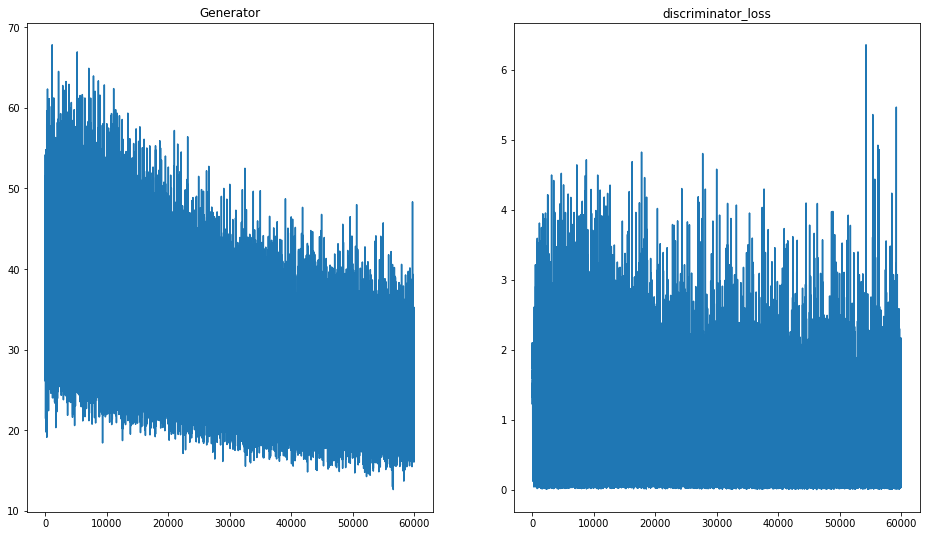

In [21]:
plt.figure(figsize=(16,9))
plt.subplot(121), plt.plot(generator_loss), plt.title('Generator')
plt.subplot(122), plt.plot(discriminator_loss), plt.title("discriminator_loss")
plt.show()

In [22]:
Generator.save("/kaggle/working/gen.h5")
Discriminator.save("/kaggle/working/gen.h5")

In [23]:
Generator.save("/kaggle/working/generator/")
Discriminator.save("/kaggle/working/discriminator/")

2022-07-19 15:21:31.350628: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


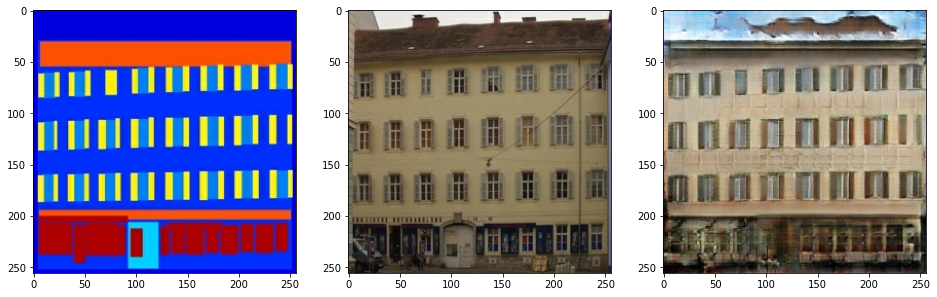

In [24]:
# below cells are having the prediciton plots


x, y = decode_img("../input/pix2pix-dataset/facades/facades/test/102.jpg")
preds = Generator.predict(tf.expand_dims(x, axis=0))

plt.figure(figsize=(16,9))
plt.subplot(131), plt.imshow(denormalize(x).numpy().astype('uint8'))
plt.subplot(132), plt.imshow(denormalize(y).numpy().astype('uint8'))
plt.subplot(133), plt.imshow(np.squeeze(denormalize(preds)).astype('uint8'))
plt.show()

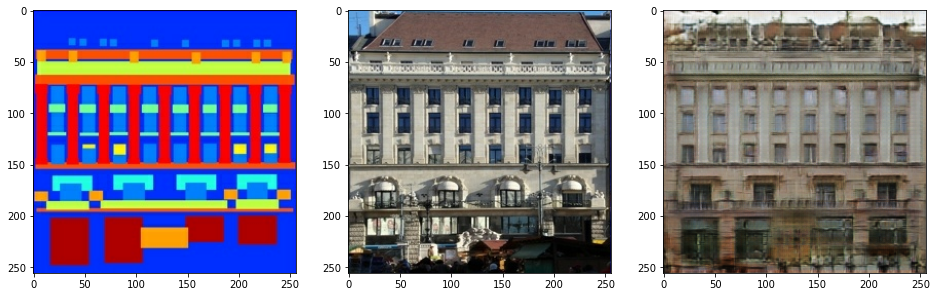

In [25]:
x, y = decode_img("../input/pix2pix-dataset/facades/facades/test/103.jpg")
preds = Generator.predict(tf.expand_dims(x, axis=0))

plt.figure(figsize=(16,9))
plt.subplot(131), plt.imshow(denormalize(x).numpy().astype('uint8'))
plt.subplot(132), plt.imshow(denormalize(y).numpy().astype('uint8'))
plt.subplot(133), plt.imshow(np.squeeze(denormalize(preds)).astype('uint8'))
plt.show()

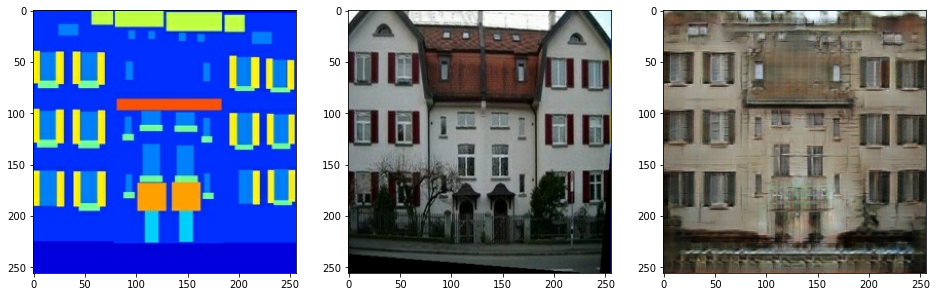

In [26]:
x, y = decode_img("../input/pix2pix-dataset/facades/facades/test/19.jpg")
preds = Generator.predict(tf.expand_dims(x, axis=0))

plt.figure(figsize=(16,9))
plt.subplot(131), plt.imshow(denormalize(x).numpy().astype('uint8'))
plt.subplot(132), plt.imshow(denormalize(y).numpy().astype('uint8'))
plt.subplot(133), plt.imshow(np.squeeze(denormalize(preds)).astype('uint8'))
plt.show()

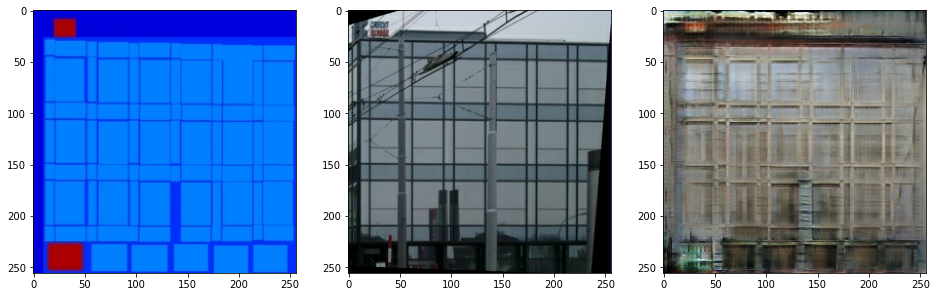

In [27]:
x, y = decode_img("../input/pix2pix-dataset/facades/facades/test/21.jpg")
preds = Generator.predict(tf.expand_dims(x, axis=0))

plt.figure(figsize=(16,9))
plt.subplot(131), plt.imshow(denormalize(x).numpy().astype('uint8'))
plt.subplot(132), plt.imshow(denormalize(y).numpy().astype('uint8'))
plt.subplot(133), plt.imshow(np.squeeze(denormalize(preds)).astype('uint8'))
plt.show()

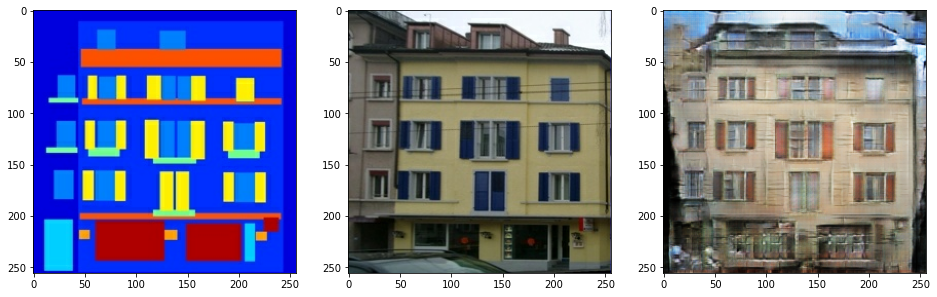

In [28]:
x, y = decode_img("../input/pix2pix-dataset/facades/facades/test/23.jpg")
preds = Generator.predict(tf.expand_dims(x, axis=0))

plt.figure(figsize=(16,9))
plt.subplot(131), plt.imshow(denormalize(x).numpy().astype('uint8'))
plt.subplot(132), plt.imshow(denormalize(y).numpy().astype('uint8'))
plt.subplot(133), plt.imshow(np.squeeze(denormalize(preds)).astype('uint8'))
plt.show()

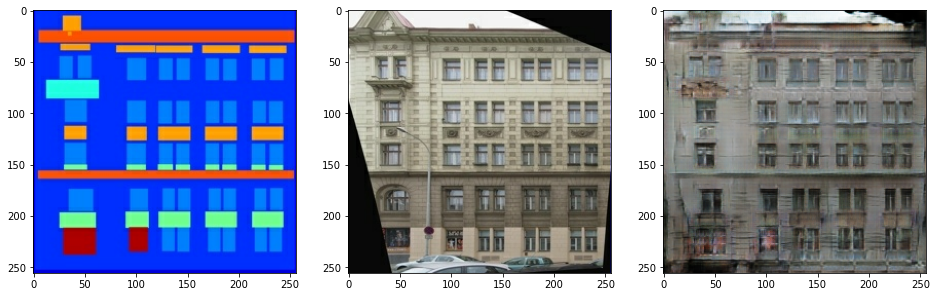

In [29]:
x, y = decode_img("../input/pix2pix-dataset/facades/facades/test/27.jpg")
preds = Generator.predict(tf.expand_dims(x, axis=0))

plt.figure(figsize=(16,9))
plt.subplot(131), plt.imshow(denormalize(x).numpy().astype('uint8'))
plt.subplot(132), plt.imshow(denormalize(y).numpy().astype('uint8'))
plt.subplot(133), plt.imshow(np.squeeze(denormalize(preds)).astype('uint8'))
plt.show()